## Imports & Constants

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.spatial import distance_matrix
import networkx as nx
import cv2
import json
import matplotlib.pyplot as plt
import os
import albumentations as A

In [3]:
DATA_PATH = '/media/hdd/VinProDatasets/3D2cut_Single_Guyot/'

In [4]:
NODE_TYPES = {
    'rootCrown': 0,
    'branchNode': 1,
    'growingTip': 2,
    'pruningCut': 3
}

BRANCH_TYPES = {
    'mainTrunk': 0,
    'courson': 1,
    'cane': 2,
    'shoot': 3,
    'lateralShoot': 4
}

## Utils

In [5]:
# Utils for data processing
def load_annotation(json_file):
    """Load JSON annotation for a vine image."""
    with open(json_file, 'r') as f:
        annotation = json.load(f)
    return annotation



def parse_features(annotation):
    """Extract vine features (nodes and branch labels) from the annotation JSON."""
    # Access the 'VineImage' list, and then the 'VineFeature' inside it
    vine_images = annotation.get('VineImage', None)

    if vine_images is None or len(vine_images) == 0:
        raise KeyError("'VineImage' key not found or empty in the JSON file. Check the JSON structure.")

    # Assuming we are dealing with the first image in the list
    features = vine_images[0].get('VineFeature', None)

    if features is None:
        raise KeyError("'VineFeature' key not found in the JSON file under 'VineImage'. Check the JSON structure.")

    nodes = []
    branches = []

    # The VineFeature is a list of lists, so we need to iterate over each inner list
    for feature_list in features:
        for feature in feature_list:
            # Check for 'FeatureType' and other keys
            if 'FeatureType' in feature and feature['FeatureType'] and 'ParentID' in feature and feature['BranchLabel']:
                    branch = 'mainTrunk' if feature['BranchLabel'] == 'root' else feature['BranchLabel']
                    branches.append({
                        'parent_id': feature['ParentID'],
                        'child_id': feature['FeatureID'],
                        'branch_label': branch
                    })
                    nodes.append({
                        'id': feature['FeatureID'],
                        'coordinates': feature['FeatureCoordinates'],
                        'type': feature['FeatureType'],
                        'branch_label': branch
                    })
    return nodes, branches

#### Vector fields

In [6]:
def generate_vector_field(image_size, field_size, branches, limb_width):
    """
    Generate vector fields for branches using point-to-segment distance with optimizations.

    Args:
        image_size (tuple): The size of the vector field (height, width).
        branches (list): List of branch segments, each defined by two nodes [(x1, y1), (x2, y2)].
        limb_width (float): The width of the vector field region.

    Returns:
        numpy.ndarray: Vector field of size (H, W, 2) with x and y components.
    """
    height, width = image_size
    H, W = field_size
    vector_field = np.zeros((H, W, 2), dtype=np.float32)

    for (x1, y1), (x2, y2) in branches:
        # Scale branch coordinates to field resolution
        x1_scaled = x1 / width * W
        y1_scaled = y1 / height * H
        x2_scaled = x2 / width * W
        y2_scaled = y2 / height * H

        # Calculate unit vector direction
        dx, dy = x2_scaled - x1_scaled, y2_scaled - y1_scaled
        segment_length_squared = dx ** 2 + dy ** 2
        if segment_length_squared == 0:
            continue
        unit_vector = (dx / np.sqrt(segment_length_squared), dy / np.sqrt(segment_length_squared))

        # Define the bounding box around the segment
        x_min = max(0, int(min(x1_scaled, x2_scaled) - limb_width))
        x_max = min(W, int(max(x1_scaled, x2_scaled) + limb_width))
        y_min = max(0, int(min(y1_scaled, y2_scaled) - limb_width))
        y_max = min(H, int(max(y1_scaled, y2_scaled) + limb_width))

        # Create grids for the bounding box
        x_grid, y_grid = np.meshgrid(np.arange(x_min, x_max), np.arange(y_min, y_max))

        # Calculate the parameter t for the projection
        t = ((x_grid - x1_scaled) * dx + (y_grid - y1_scaled) * dy) / segment_length_squared

        # Clamp t to the range [0, 1]
        t_clamped = np.clip(t, 0, 1)

        # Compute the closest points on the segment
        closest_x = x1_scaled + t_clamped * dx
        closest_y = y1_scaled + t_clamped * dy

        # Compute the distance from each point in the grid to the segment
        distances = np.sqrt((x_grid - closest_x) ** 2 + (y_grid - closest_y) ** 2)

        # Find points within the limb width and assign vector values
        mask = distances <= limb_width
        vector_field[y_min:y_max, x_min:x_max, 0][mask] = unit_vector[0]
        vector_field[y_min:y_max, x_min:x_max, 1][mask] = unit_vector[1]

    return vector_field
    
def get_couples(branches_k, nodes_k):
    couples = {
        'mainTrunk': list(),
        'courson': list(),
        'cane': list(),
        'shoot': list(),
        'lateralShoot': list()
    }
    
    for b in branches_k:
    
        parent_node = next((node for node in nodes_k if node['id'] == b['parent_id']), None)
        child_node = next((node for node in nodes_k if node['id'] == b['child_id']), None)
        if parent_node is None or child_node is None:
            continue
        tuple = (parent_node['coordinates'], child_node['coordinates'])
    
        if b['branch_label'] not in couples.keys():
            continue
    
        couples[b['branch_label']].append(tuple)

    return couples


def get_vector_fields(initial_dims, final_dims, nodes, branches):
    
    couples = get_couples(branches, nodes)
    
    vector_fields = dict()

    for k, c in couples.items():
        limb_width = 3
        vector_field = generate_vector_field(initial_dims, final_dims, c, limb_width)
        vector_fields[k] = vector_field

    return vector_fields

#### Heatmaps

In [7]:
def convert_nodes(nodes, branches, branch_types, node_types):
    
    new_nodes = list()
    
    for n in nodes:
        if n['type'] not in node_types.keys() or n['branch_label'] not in branch_types.keys():
            continue
        new_nodes.append((n['coordinates'], node_types[n['type']], branch_types[n['branch_label']]))

    return new_nodes

In [8]:
def generate_node_heatmaps(image_size, nodes, sigma, num_node_types, num_branch_types, new_size):
    """
    Generate heatmaps for each node type and branch type with optimized performance.

    Args:
        image_size (tuple): Original size of the image (H, W).
        nodes (list): List of node coordinates, node types, and branch types [((x, y), node_type, branch_type), ...].
        sigma (float): Gaussian spread for the heatmap.
        num_node_types (int): Total number of node types.
        num_branch_types (int): Total number of branch types.
        new_size (tuple): Target resolution for heatmaps (H, W).

    Returns:
        numpy.ndarray: Heatmaps of shape (num_branch_types, num_node_types, new_size[0], new_size[1]).
    """
    height, width = image_size
    new_height, new_width = new_size
    heatmaps = np.zeros((num_branch_types, num_node_types, new_height, new_width), dtype=np.float32)
    scaling_factor_x = new_width / width
    scaling_factor_y = new_height / height

    for (x, y), node_type, branch_type in nodes:
        # Scale node coordinates to new resolution
        x_scaled = int(x * scaling_factor_x)
        y_scaled = int(y * scaling_factor_y)

        # Define a bounding box around the node
        x_min = max(0, int(x_scaled - 3 * sigma))
        x_max = min(new_width, int(x_scaled + 3 * sigma))
        y_min = max(0, int(y_scaled - 3 * sigma))
        y_max = min(new_height, int(y_scaled + 3 * sigma))

        # Generate Gaussian within the bounding box
        x_range = np.arange(x_min, x_max)
        y_range = np.arange(y_min, y_max)
        x_grid, y_grid = np.meshgrid(x_range, y_range)

        heatmap_patch = np.exp(-((x_grid - x_scaled) ** 2 + (y_grid - y_scaled) ** 2) / (2 * sigma ** 2))
        heatmaps[branch_type, node_type, y_min:y_max, x_min:x_max] += heatmap_patch

    # Clip to [0, 1] for visualization
    np.clip(heatmaps, 0, 1, out=heatmaps)
    return heatmaps

## Dataset

In [9]:
class VineDataset(Dataset):
    """Custom dataset for vine images and annotations stored in the same folder."""
    def __init__(self, data_dir, transforms, node_types, branch_types, new_height, new_width, type, sigma=1.5):
        super(VineDataset, self).__init__()

        self.data_dir = data_dir

        self.node_types = node_types
        self.branch_types = branch_types

        self.sigma = sigma
        self.transforms = transforms

        self.new_height = new_height
        self.new_width = new_width

        # Get list of image files
        if type == 'train':
            self.image_files = [f for f in os.listdir(data_dir) if (f.endswith('.jpg') or f.endswith('.jpeg')) and any(f'Set0{x}' in f for x in range(0, 5))]
        elif type == 'val':
            self.image_files = [f for f in os.listdir(data_dir) if (f.endswith('.jpg') or f.endswith('.jpeg')) and any(f'Set0{x}' in f for x in range(5, 7))]
        elif type == 'test':
            self.image_files = [f for f in os.listdir(data_dir) if (f.endswith('.jpg') or f.endswith('.jpeg'))]


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):

        img_file = self.image_files[idx]
        img_path = os.path.join(self.data_dir, img_file)
        annotation_path = os.path.join(self.data_dir, img_file.replace('.jpg', '_annotation.json').replace('.jpeg', '_annotation.json'))

        # Load and resize image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        real_height, real_width, layers = image.shape
        if self.transforms:
            image = self.transforms(image=image)['image']


        # Load and parse annotation
        annotation = load_annotation(annotation_path)
        nodes, branches = parse_features(annotation)

        # image = A.ToTensorV2()(image=image)['image']
        image = torch.tensor(image).permute(2, 0, 1)

        vector_fields = get_vector_fields((real_height, real_width),(self.new_height, self.new_width), nodes, branches)
        

        # Generate heatmaps for nodes
        new_nodes = convert_nodes(nodes, branches, self.branch_types, self.node_types)
        heatmaps = generate_node_heatmaps((real_height, real_width), new_nodes, self.sigma, len(self.node_types), len(self.branch_types), (self.new_height, self.new_width))
        

        vector_fields = np.array([vec_field.transpose(2, 0, 1) for vec_field in vector_fields.values()])
        vector_fields = torch.tensor(vector_fields)
        vector_fields = vector_fields.view(2*len(self.branch_types), self.new_height, self.new_width)

        heatmaps = torch.tensor(heatmaps)
        heatmaps = heatmaps.view(len(self.branch_types) * len(self.node_types), self.new_height, self.new_width)

        M = torch.vstack([heatmaps, vector_fields])

        # Convert to PyTorch tensors
        return image, M

## Plotting

In [10]:
from torchvision.transforms import v2

def plot_heatmaps(heatmaps, image=None):
    fig, axes = plt.subplots(len(BRANCH_TYPES), len(NODE_TYPES), figsize=(20, 20))
    for bname, branch_type in BRANCH_TYPES.items():
        for nname, node_type in NODE_TYPES.items():
            ax = axes[branch_type, node_type]
            if image is not None:
                image = v2.Resize(size = 256)(image)
                ax.imshow(image.permute(1, 2, 0))
            ax.imshow(heatmaps[branch_type, node_type], cmap='hot', alpha=0.7 if image is not None else 1)
            ax.set_title(f"{bname}, {nname}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

def plot_vector_fields(vector_fields, image=None):
    fig, axes = plt.subplots(len(BRANCH_TYPES), 3, figsize=(15, 20))
    for bname, branch_type in BRANCH_TYPES.items():
        for i in range(2):
            ax = axes[branch_type, i]
            if image is not None:
                image = v2.Resize(size = 256)(image)
                ax.imshow(image.permute(1, 2, 0))
            ax.imshow(vector_fields[branch_type, i], cmap='viridis', alpha=0.7 if image is not None else 1)
            ax.set_title(f"{bname}, {'xy'[i]}")
            ax.axis('off')
        ax = axes[branch_type, 2]
        if image is not None:
            ax.imshow(image.permute(1, 2, 0))
        ax.imshow(np.sqrt(vector_fields[branch_type, 0] ** 2 + vector_fields[branch_type, 1] ** 2), cmap='viridis', alpha=0.9)
        ax.set_title(f"{bname}, magnitude")
    plt.tight_layout()
    plt.show()

# Training

### Variables and Hyperparameters

### Utils

In [11]:
def recover_heatmaps_vector_fields(M):
    if M.dim() == 4:
        batch_size = M.size(0)
        heatmaps = M[:, :len(BRANCH_TYPES) * len(NODE_TYPES), :, :]
        vector_fields = M[:, -len(BRANCH_TYPES) * 2:, :, :]

        heatmaps = heatmaps.view(batch_size, len(BRANCH_TYPES), len(NODE_TYPES), RESIZE[0], RESIZE[1])
        vector_fields = vector_fields.view(batch_size, len(BRANCH_TYPES), 2, RESIZE[0], RESIZE[1])
    else:
        heatmaps = M[:len(BRANCH_TYPES) * len(NODE_TYPES), :, :]
        vector_fields = M[-len(BRANCH_TYPES) * 2:, :, :]

        heatmaps = heatmaps.view(len(BRANCH_TYPES), len(NODE_TYPES), RESIZE[0], RESIZE[1])
        vector_fields = vector_fields.view(len(BRANCH_TYPES), 2, RESIZE[0], RESIZE[1])

    return heatmaps, vector_fields

### Dataloaders

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
RESIZE = (256, 256)
BATCH_SIZE = 1
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
# num_workers = 0
num_workers = 18 if device.type == 'cuda' else 0

# Create a DataLoader
transforms = A.Compose([
    A.Resize(1024, 1024)
    # A.Rescale(1100, 1300),  # Resize images to target input size
    # A.CentrCrop(1024, 1024),
    # A.HorizontalFlip(p=0.5),
    # A.Rotate(limit=15, p=0.5),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

train_dataset = VineDataset(DATA_PATH + '01-TrainAndValidationSet', transforms, NODE_TYPES, BRANCH_TYPES, RESIZE[0], RESIZE[1], type='train')
val_dataset = VineDataset(DATA_PATH + '01-TrainAndValidationSet', transforms, NODE_TYPES, BRANCH_TYPES, RESIZE[0], RESIZE[1], type='val')
test_dataset = VineDataset(DATA_PATH + '02-IndependentTestSet', transforms, NODE_TYPES, BRANCH_TYPES, RESIZE[0], RESIZE[1], type='test')

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=num_workers)

Train dataset size: 794
Validation dataset size: 460
Test dataset size: 257


/home/vinpro/ViNet-paper-replica/VinPRO/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 18 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


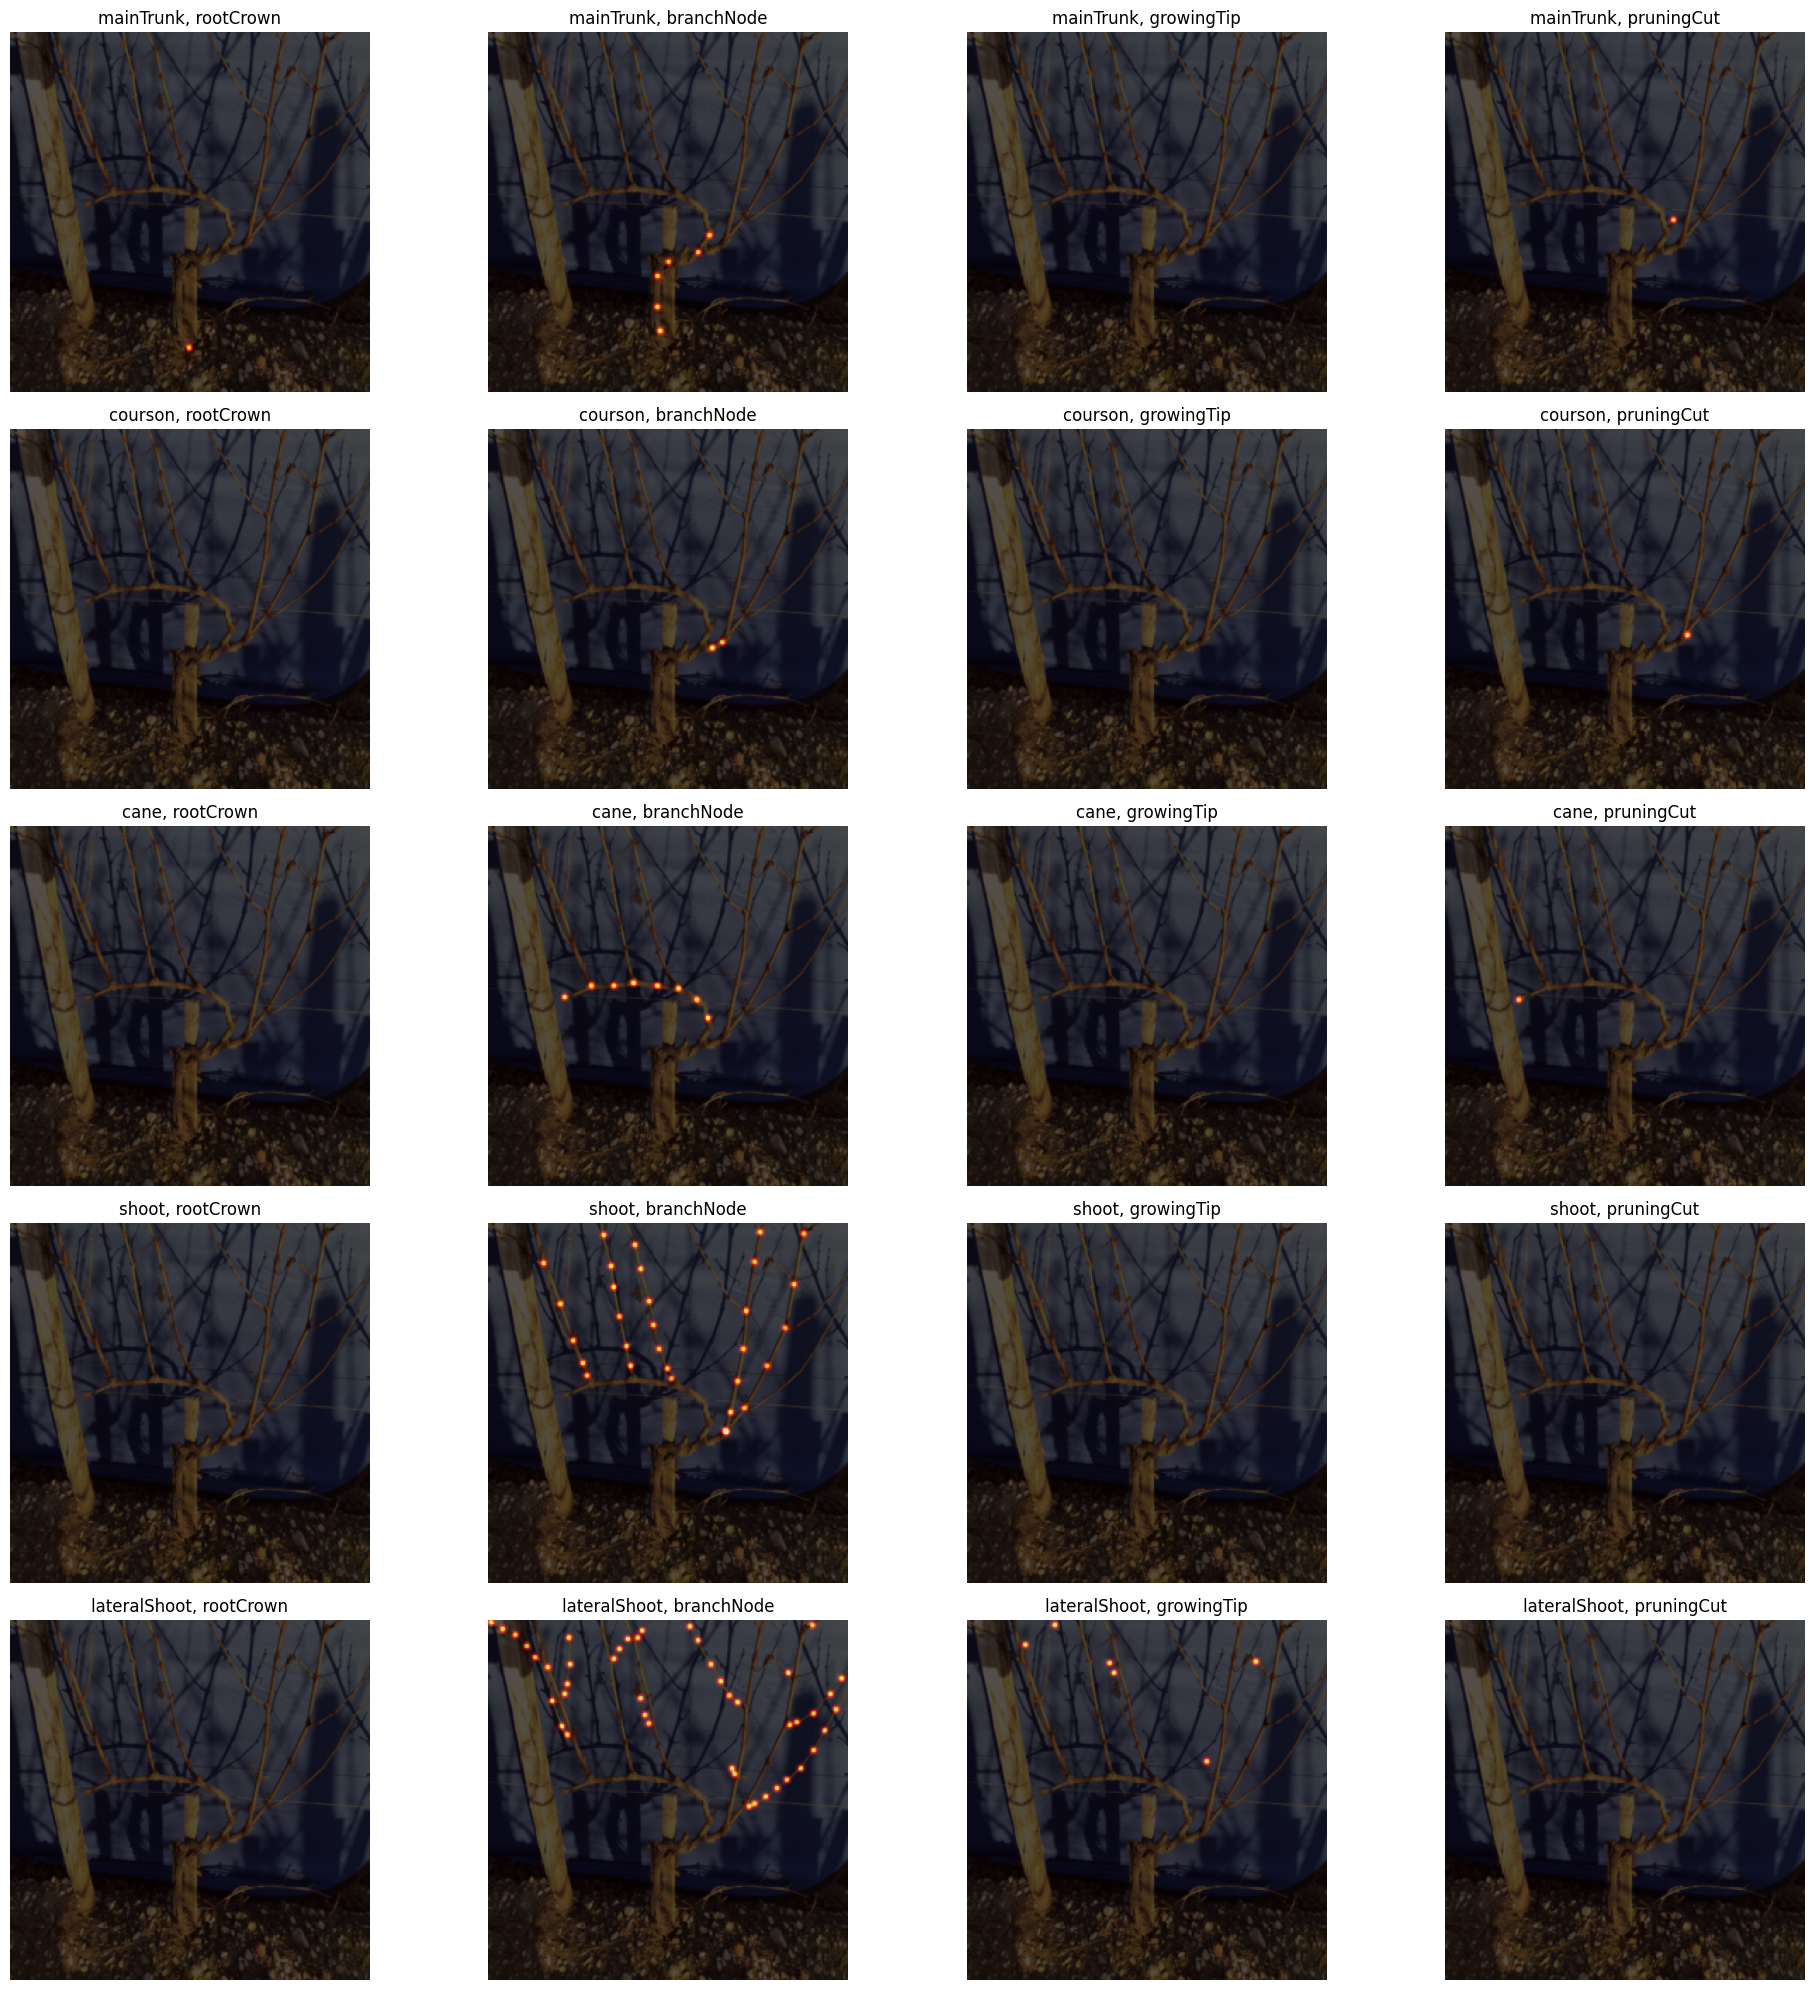

/tmp/ipykernel_3819866/3939418835.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax.imshow(np.sqrt(vector_fields[branch_type, 0] ** 2 + vector_fields[branch_type, 1] ** 2), cmap='viridis', alpha=0.9)


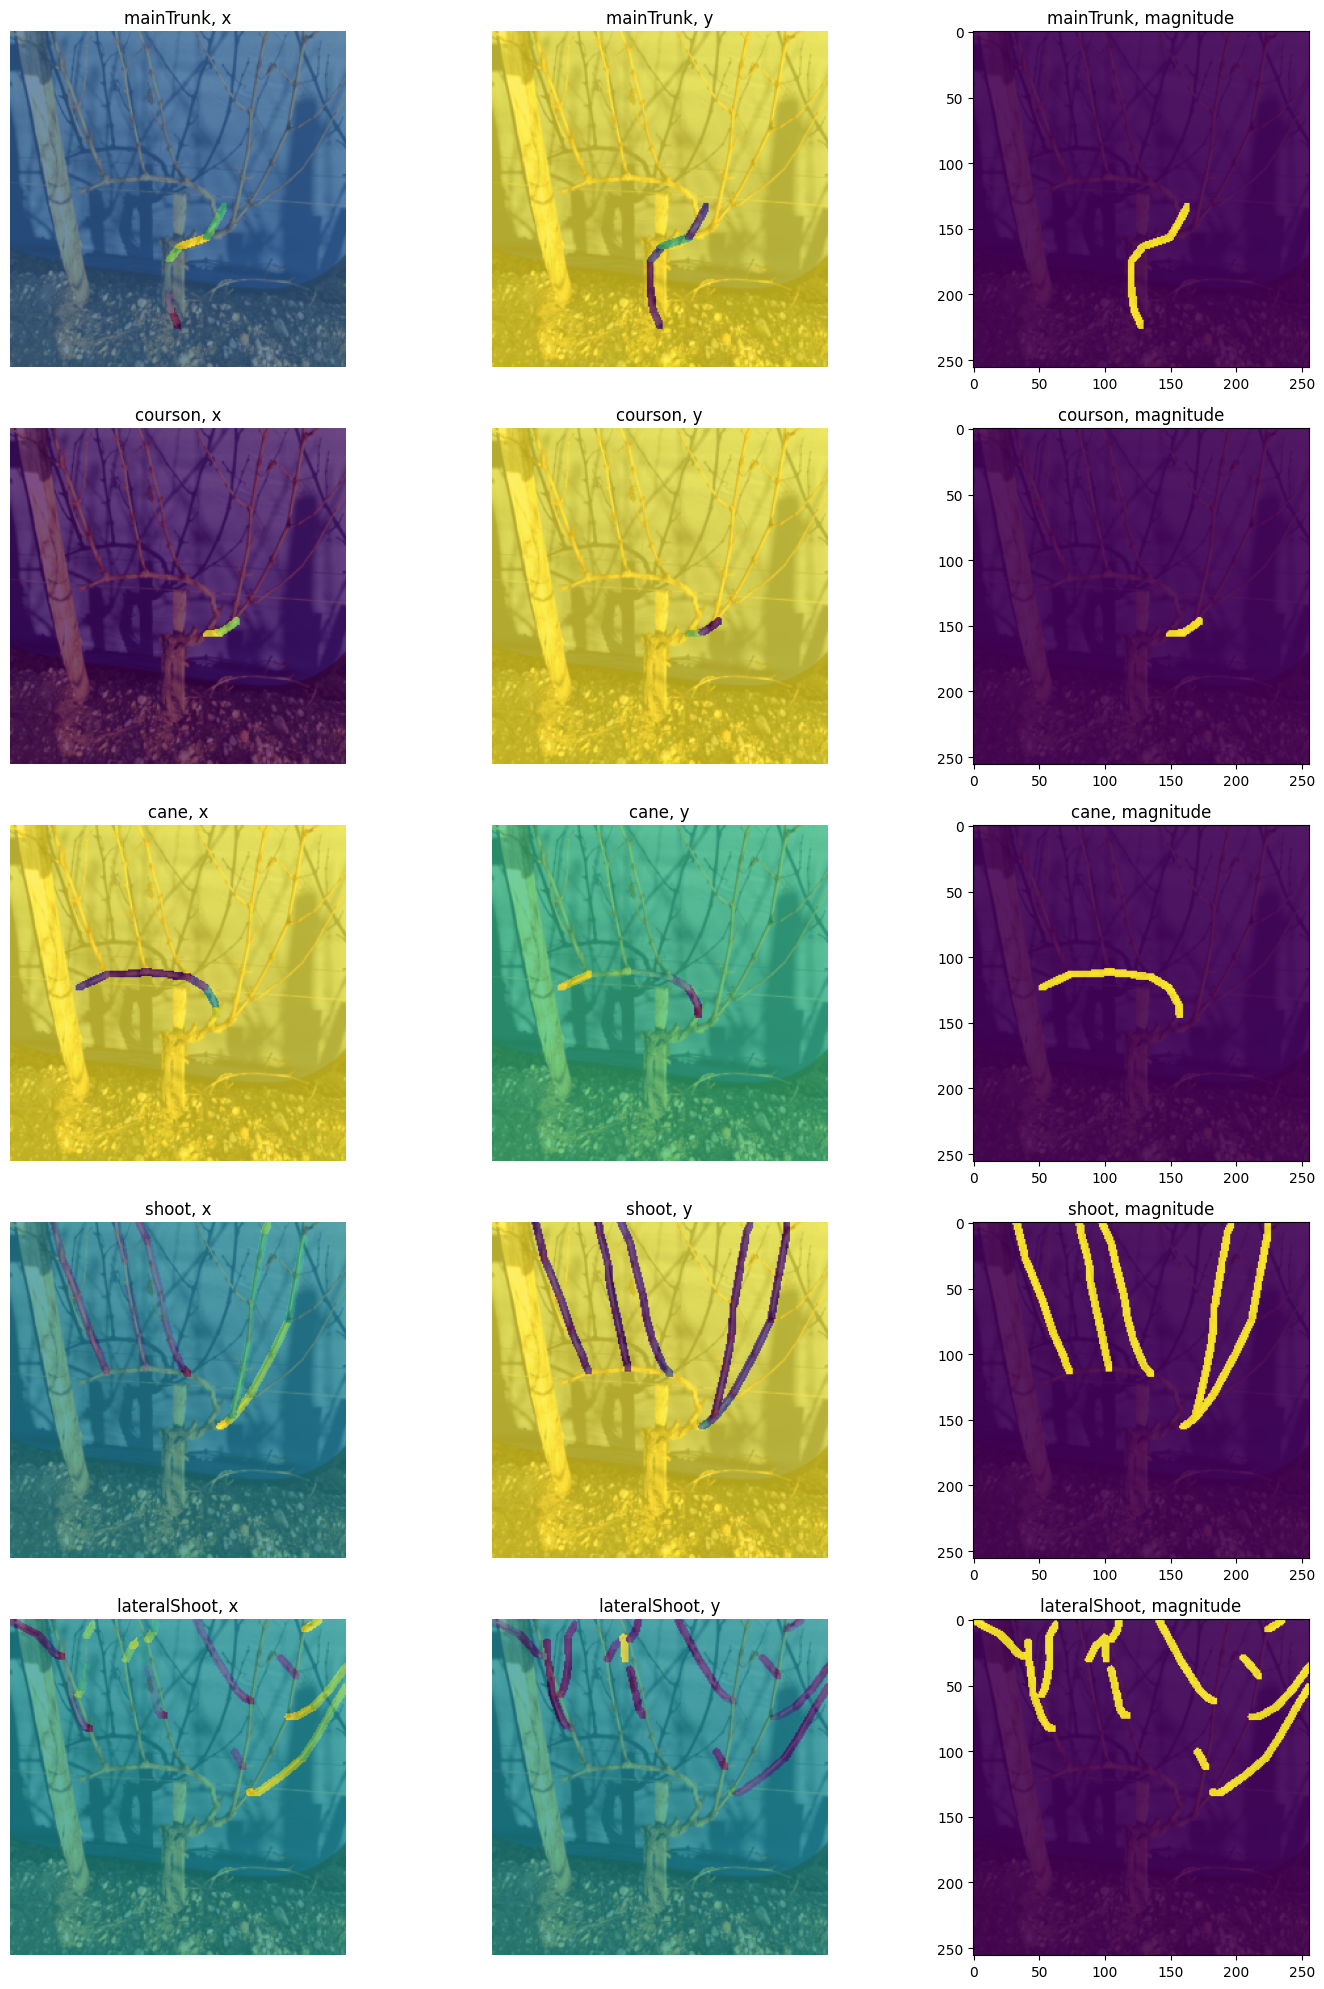

In [13]:
i = 0
for images, M in train_loader:

    for k, image in enumerate(images):
        heatmaps, vector_fields = recover_heatmaps_vector_fields(M[k])
        plot_heatmaps(heatmaps, image)
        plot_vector_fields(vector_fields, image)
        break
    break

### Model definition

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --------------------------------------------------
# 1) ResidualUnit + TripleResidualBlock (for reuse)
# --------------------------------------------------
class ResidualUnit(nn.Module):
    """
    One 'residual unit':
      Conv(1x1) -> IN -> ReLU
      Conv(3x3) -> IN -> ReLU
      Conv(1x1) -> IN
    plus skip connection.
    """
    def __init__(self, num_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(num_channels, num_channels, kernel_size=1, padding=0, bias=False)
        self.in1   = nn.InstanceNorm2d(num_channels, affine=False)

        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, bias=False)
        self.in2   = nn.InstanceNorm2d(num_channels, affine=False)

        self.conv3 = nn.Conv2d(num_channels, num_channels, kernel_size=1, padding=0, bias=False)
        self.in3   = nn.InstanceNorm2d(num_channels, affine=False)

    def forward(self, x):
        skip = x
        out = F.relu(self.in1(self.conv1(x)), inplace=True)
        out = F.relu(self.in2(self.conv2(out)), inplace=True)
        out = self.in3(self.conv3(out))
        out = skip + out
        out = F.relu(out, inplace=True)
        return out

class TripleResidualBlock(nn.Module):
    """
    A block of three consecutive residual units.
    """
    def __init__(self, num_channels):
        super().__init__()
        self.ru1 = ResidualUnit(num_channels)
        self.ru2 = ResidualUnit(num_channels)
        self.ru3 = ResidualUnit(num_channels)

    def forward(self, x):
        x = self.ru1(x)
        x = self.ru2(x)
        x = self.ru3(x)
        return x

# --------------------------------------------------
# 2) FeatureExtractor (Front module)
# --------------------------------------------------
class FeatureExtractor(nn.Module):
    """
    Reduces input resolution by 4x and refines features,
    producing a tensor of shape ~ (B, hourglass_channels, H/4, W/4).
    """
    def __init__(self, in_channels=3, front_channels=64, hourglass_channels=256):
        super().__init__()
        # 7x7 conv, stride=2 => /2 resolution
        self.conv7 = nn.Conv2d(in_channels, front_channels,
                               kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.in7   = nn.InstanceNorm2d(front_channels, affine=False)

        # maxpool => another /2 => total /4
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)

        # One triple residual block at /4 resolution
        self.triple_res = TripleResidualBlock(front_channels)

        # Match channels (front_channels -> hourglass_channels)
        self.match_conv = nn.Conv2d(front_channels, hourglass_channels,
                                    kernel_size=1, bias=False)
        self.match_in   = nn.InstanceNorm2d(hourglass_channels, affine=False)

    def forward(self, x):
        # 7x7 conv -> IN -> ReLU
        x = self.conv7(x)
        x = F.relu(self.in7(x), inplace=True)

        # max pool => /4
        x = self.pool(x)

        # triple res block
        x = self.triple_res(x)

        # channel match for hourglass
        x = self.match_conv(x)
        x = self.match_in(x)
        x = F.relu(x, inplace=True)
        return x

# --------------------------------------------------
# 3) HourglassModule
# --------------------------------------------------
class HourglassModule(nn.Module):
    """
    Processes features at multiple scales (depth=5):
      down -> down -> down -> down -> bottom
      up -> up -> up -> up, with skip connections
    plus final aggregator block B6.
    """
    def __init__(self, num_channels, depth=5):
        super().__init__()
        assert depth == 5, "For this example we fix the hourglass depth to 5."

        # Down path (B1..B5)
        self.down1 = TripleResidualBlock(num_channels)
        self.down2 = TripleResidualBlock(num_channels)
        self.down3 = TripleResidualBlock(num_channels)
        self.down4 = TripleResidualBlock(num_channels)
        self.down5 = TripleResidualBlock(num_channels)  # bottom

        # Skip blocks (S1..S4)
        self.skip1 = TripleResidualBlock(num_channels)
        self.skip2 = TripleResidualBlock(num_channels)
        self.skip3 = TripleResidualBlock(num_channels)
        self.skip4 = TripleResidualBlock(num_channels)

        # Upsample layers
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        # Final aggregator block B6
        self.b6 = TripleResidualBlock(num_channels)

    def forward(self, x):
        # Level 1
        d1 = self.down1(x)
        out = F.max_pool2d(d1, kernel_size=2, stride=2)

        # Level 2
        d2 = self.down2(out)
        out = F.max_pool2d(d2, kernel_size=2, stride=2)

        # Level 3
        d3 = self.down3(out)
        out = F.max_pool2d(d3, kernel_size=2, stride=2)

        # Level 4
        d4 = self.down4(out)
        out = F.max_pool2d(d4, kernel_size=2, stride=2)

        # Level 5 (bottom)
        d5 = self.down5(out)

        # Up path (back to level 4)
        out = self.up4(d5)
        out = out + self.skip4(d4)

        # Level 3
        out = self.up3(out)
        out = out + self.skip3(d3)

        # Level 2
        out = self.up2(out)
        out = out + self.skip2(d2)

        # Level 1
        out = self.up1(out)
        out = out + self.skip1(d1)

        # Final aggregator block (B6)
        out = self.b6(out)
        return out

# --------------------------------------------------
# 4) StackedHourglassNetwork
# --------------------------------------------------
class StackedHourglassNetwork(nn.Module):
    """
    2 hourglass modules stacked, with:
      - FeatureExtractor to get ~ (B, hourglass_channels, H/4, W/4)
      - Hourglass #1 -> output #1
      - Merge features for second hourglass
      - Hourglass #2 -> output #2
    """
    def __init__(self,
                 in_channels=3,
                 front_channels=64,
                 hourglass_channels=256,
                 num_output_channels=20):
        super().__init__()

        # FeatureExtractor module
        self.feature_extractor = FeatureExtractor(
            in_channels=in_channels,
            front_channels=front_channels,
            hourglass_channels=hourglass_channels
        )

        # Hourglass #1 and post block
        self.hg1       = HourglassModule(hourglass_channels, depth=5)
        self.hg1_post  = TripleResidualBlock(hourglass_channels)
        self.out_stage1 = nn.Conv2d(hourglass_channels, num_output_channels,
                                    kernel_size=1, bias=True)

        # For feeding stage1 output into stage2
        self.merge_feat1 = nn.Conv2d(hourglass_channels, hourglass_channels,
                                     kernel_size=1, bias=False)
        self.merge_pred1 = nn.Conv2d(num_output_channels, hourglass_channels,
                                     kernel_size=1, bias=False)

        # Hourglass #2 and post block
        self.hg2       = HourglassModule(hourglass_channels, depth=5)
        self.hg2_post  = TripleResidualBlock(hourglass_channels)
        self.out_stage2 = nn.Conv2d(hourglass_channels, num_output_channels,
                                    kernel_size=1, bias=True)

    def forward(self, x):
        """
        Args:
          x: input image, shape (B, 3, H, W).
        Returns:
          pred_stage1, pred_stage2: (B, num_output_channels, H/4, W/4)
        """

        # 1) Extract features at 1/4 resolution
        features = self.feature_extractor(x)

        # 2) Hourglass #1
        y1 = self.hg1(features)
        # y1 = self.hg1_post(y1)
        pred_stage1 = self.out_stage1(y1)

        # Merge stage1 output for stage2
        feat1 = self.merge_feat1(y1) + self.merge_pred1(pred_stage1)

        # 3) Hourglass #2
        y2 = self.hg2(feat1)
        y2 = self.hg2_post(y2)
        pred_stage2 = self.out_stage2(y2)

        return pred_stage1, pred_stage2

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

class HourglassLightningModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3):
        """
        model: a two-stage stacked hourglass network
        lr:    learning rate
        """
        super().__init__()
        self.model = model  # e.g. StackedHourglassNetwork
        self.criterion = nn.MSELoss()  # or SmoothL1Loss, etc.
        self.lr = lr

    def forward(self, x):
        """Normal forward pass: x -> (out1, out2)."""
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """
        batch: (images, M)
          images: (B, 3, H, W)
          M: (B, num_output_channels, H/4, W/4) or similar
        """
        images, M = batch
        out1, out2 = self.forward(images.float())
        loss1 = self.criterion(out1, M)
        loss2 = self.criterion(out2, M)
        loss = loss1 + loss2

        # Logging to TensorBoard (by default) under key 'train_loss'
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, M = batch
        out1, out2 = self.forward(images.float())
        loss1 = self.criterion(out1, M)
        loss2 = self.criterion(out2, M)
        val_loss = loss1 + loss2
        self.log("val_loss", val_loss, on_step=False, on_epoch=True, prog_bar=True)
        return val_loss

    def configure_optimizers(self):
        """
        Returns an optimizer + LR scheduler dict for PyTorch Lightning.
        Using a StepLR here, but you can pick others (MultiStepLR, ExponentialLR, etc.)
        """
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        
        # Create the scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",          # we want to reduce LR when 'val_loss' is not improving (lower is better)
            factor=0.1,  # multiply LR by 0.1, for example
            patience=5,
            verbose=True         # prints a message when LR is reduced
        )

        # Lightning looks for 'lr_scheduler' and 'monitor' in the returned dict
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,   # pass the scheduler
            "monitor": "val_loss"       # metric to monitor
        }

### Training/evaluation loop

In [18]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

model = StackedHourglassNetwork(
        in_channels=3,
        front_channels=64,
        hourglass_channels=256,
        num_output_channels=30
    ).to(device)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',              # metric to monitor
        filename='hourglass-{epoch:02d}-{val_loss:.4f}',
        save_top_k=1,                    # keep only best 3
        mode='min'                       # 'val_loss' should go down
    )

# 3) Wrap the model in our LightningModule
lightning_model = HourglassLightningModule(model, lr=1e-3)

# 4) Define the Trainer
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",  # or "cpu"
    callbacks=[checkpoint_callback]
)

# 5) Fit
trainer.fit(lightning_model, train_loader, val_loader)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/vinpro/ViNet-paper-replica/VinPRO/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/vinpro/ViNet-paper-replica/VinPRO/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 18 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0:   0%|          | 0/794 [00:00<?, ?it/s]                           

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 7.61 GiB of which 52.00 MiB is free. Including non-PyTorch memory, this process has 7.39 GiB memory in use. Of the allocated memory 7.21 GiB is allocated by PyTorch, and 44.21 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [16]:
# 6) The best checkpoint file is stored in:
best_ckpt_path = checkpoint_callback.best_model_path
print("Best checkpoint:", best_ckpt_path)

Best checkpoint: /kaggle/working/lightning_logs/version_0/checkpoints/hourglass-epoch=47-val_loss=0.0062.ckpt


In [17]:
torch.save(model.state_dict(), "model.pt")

In [18]:
model = model.to(device)

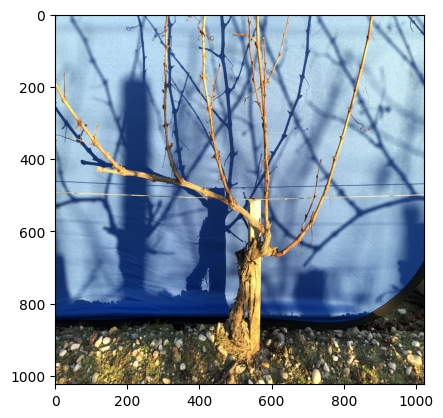

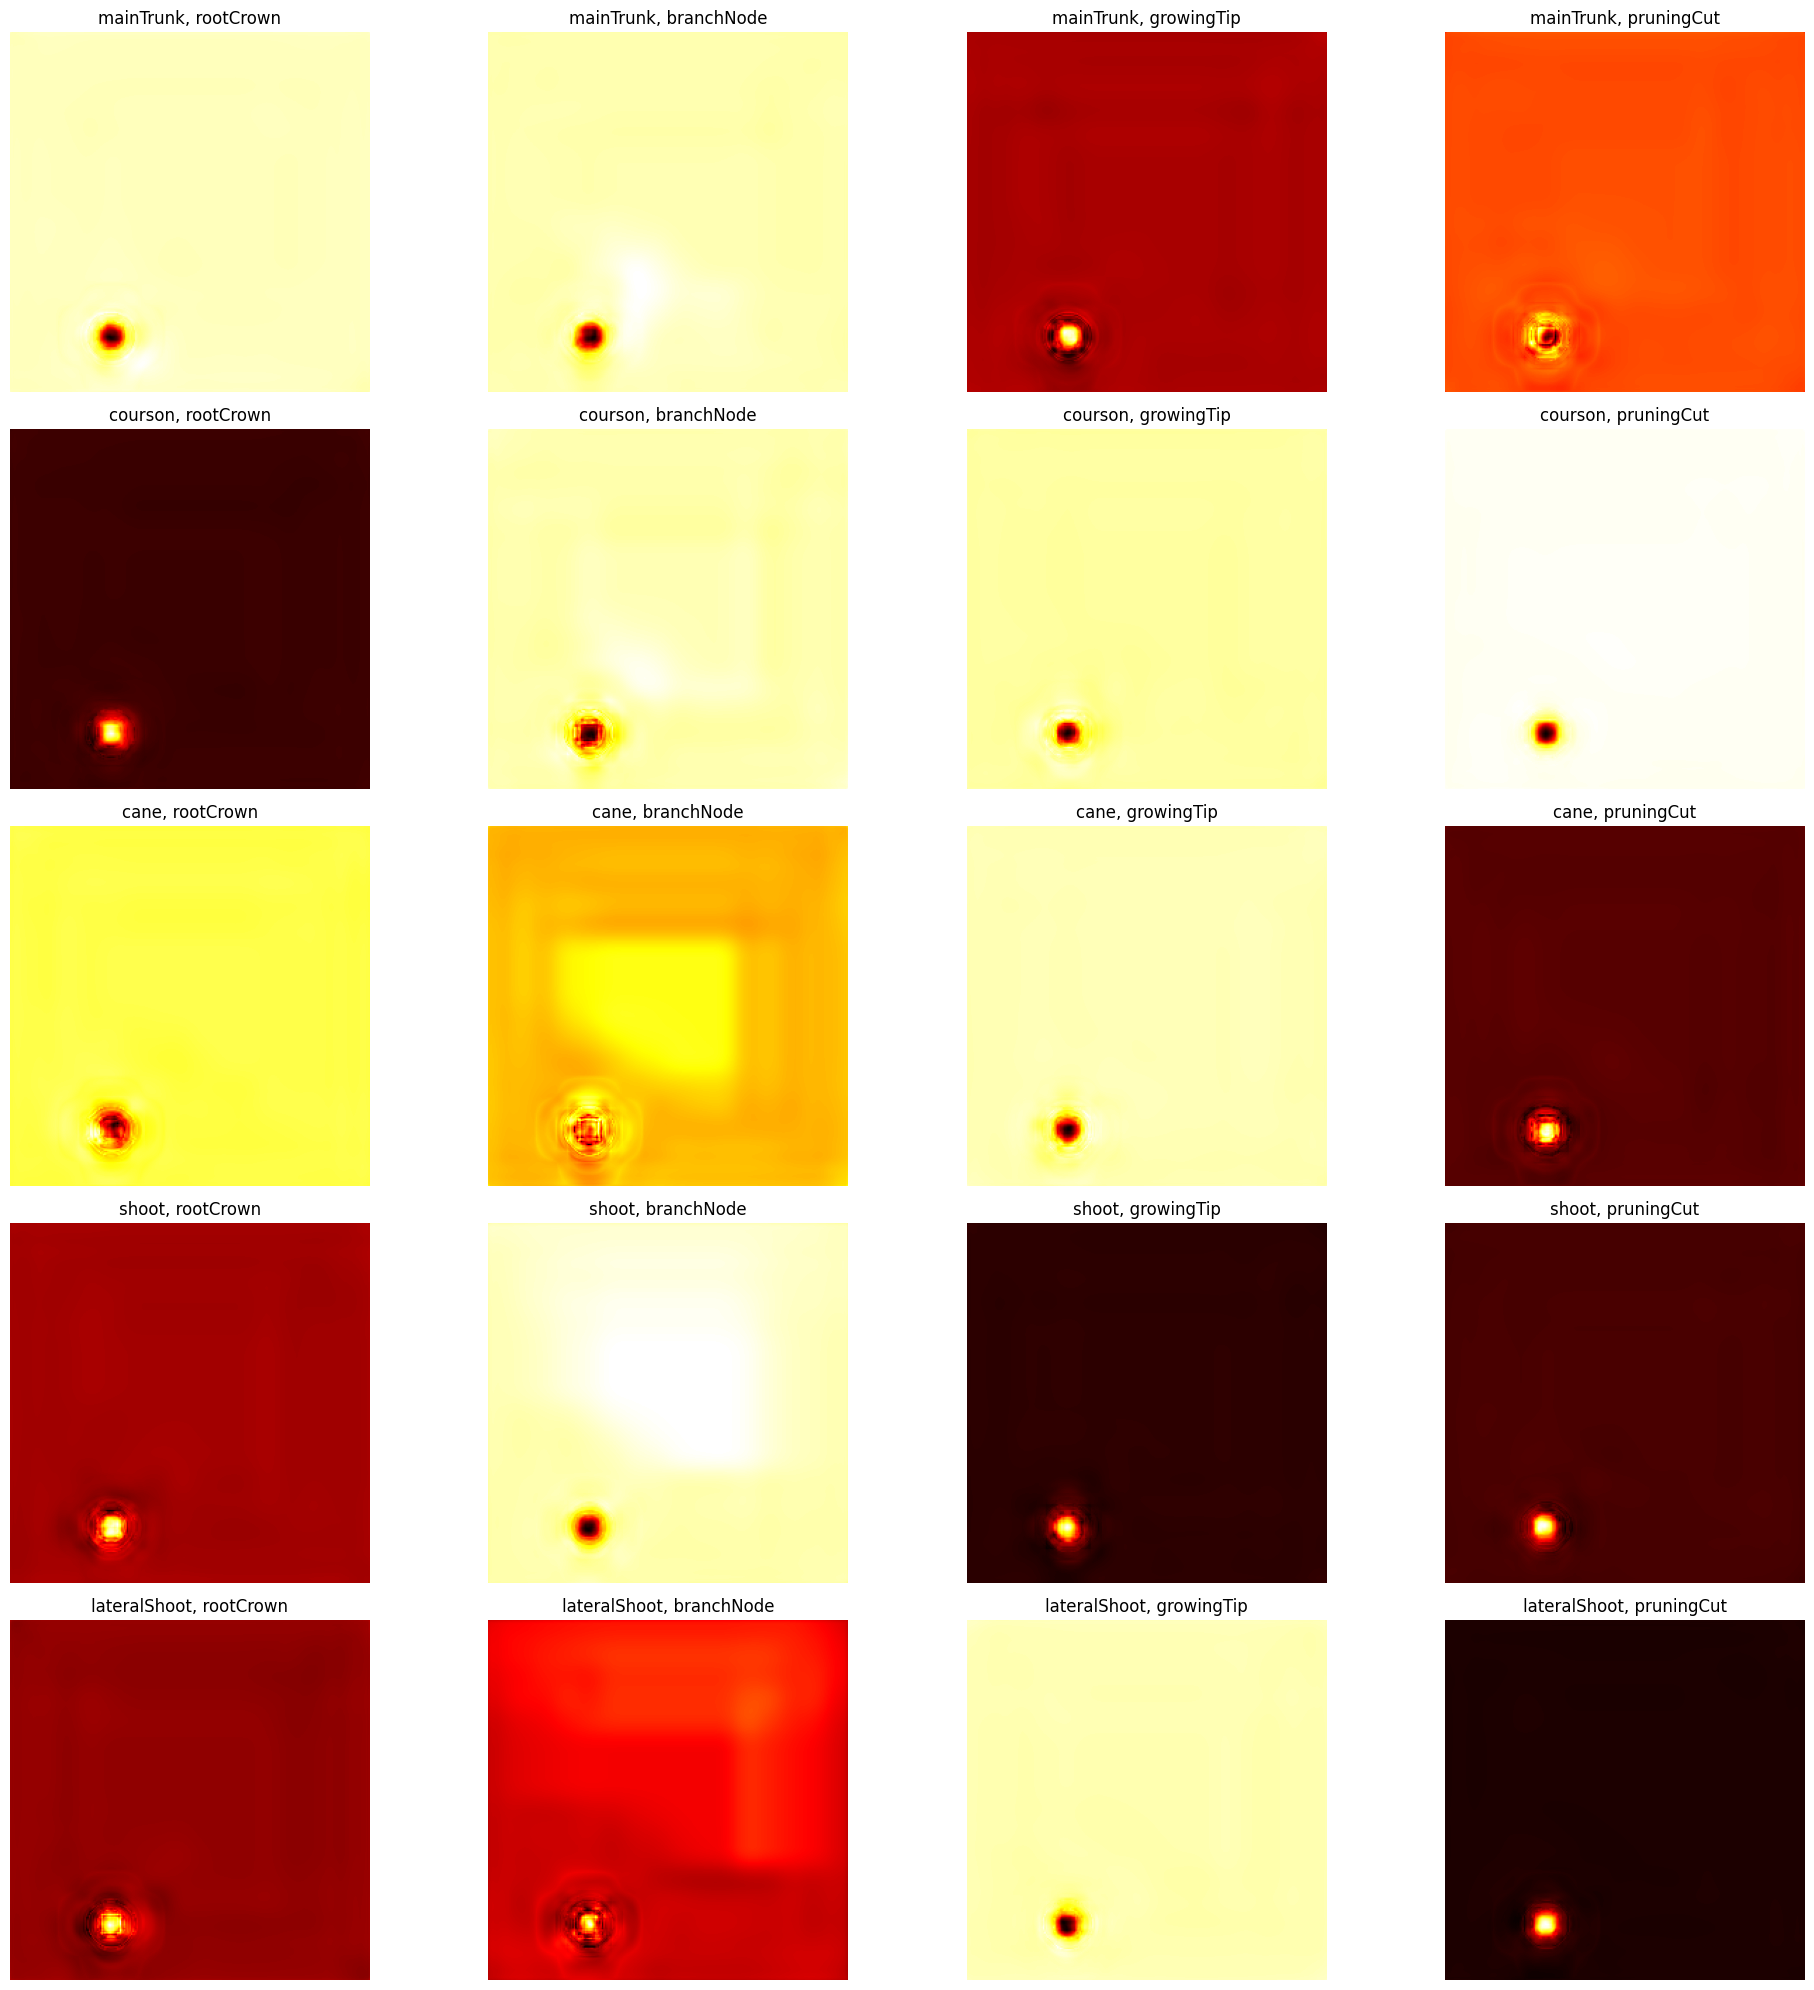

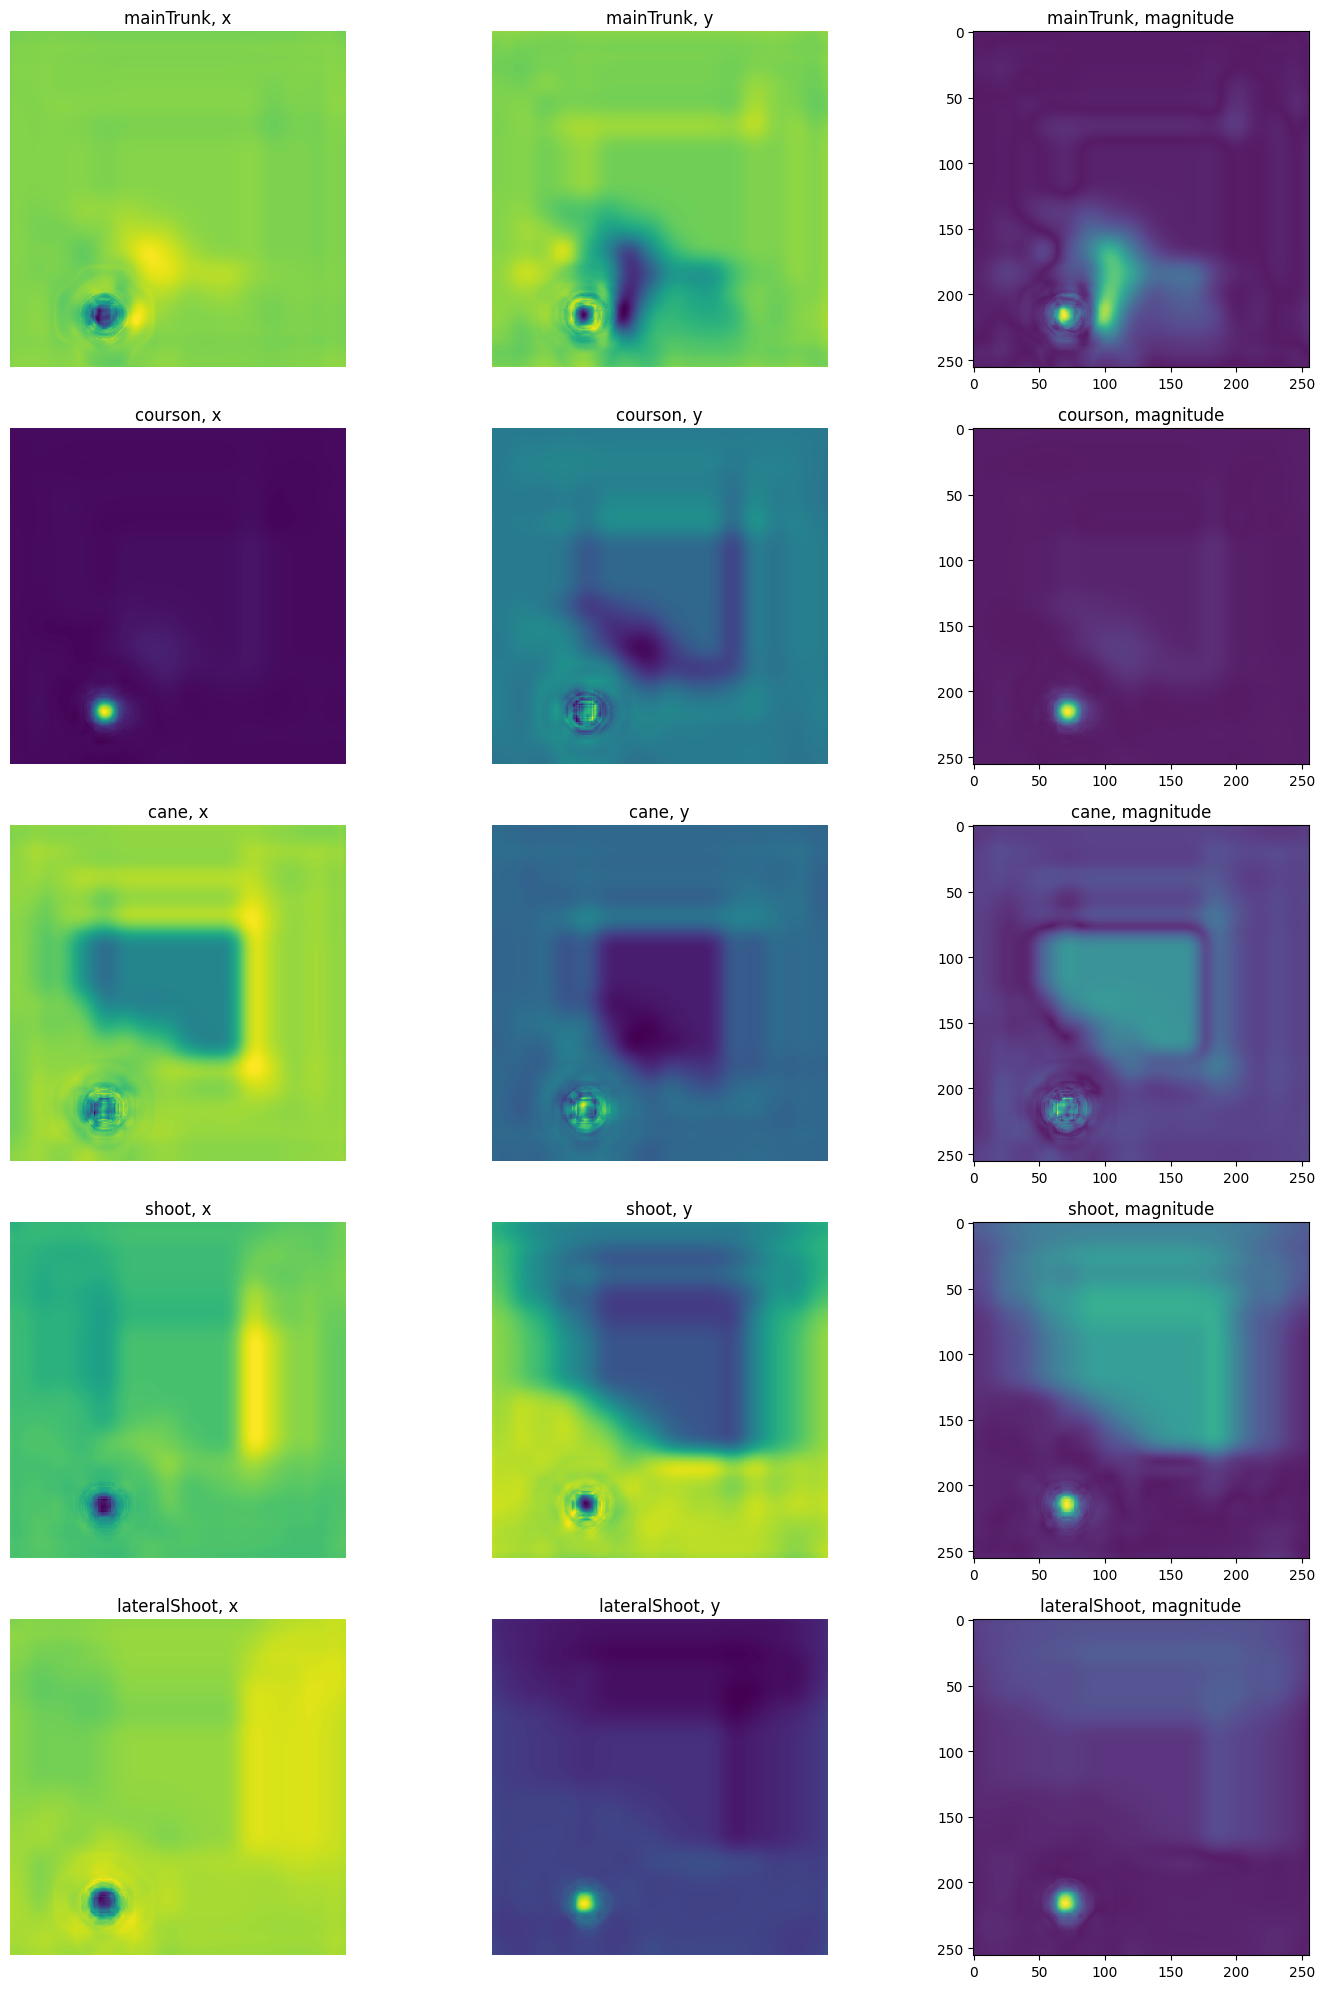

In [ ]:
dataset = VineDataset(DATA_PATH + '02-IndependentTestSet', transforms, NODE_TYPES, BRANCH_TYPES, RESIZE[0], RESIZE[1], type='test')
image, M = dataset[19]

plt.imshow(image.permute(1, 2, 0))
output1, output2 = model(image.unsqueeze(0).float().to(device))
heatmaps, vector_fields = recover_heatmaps_vector_fields(output2[0].to('cpu').detach())
plot_heatmaps(heatmaps)
plot_vector_fields(vector_fields)

### Test loop

In [20]:
model.eval()
test_loss = 0
with torch.no_grad():
    for images, M in test_loader:
        images = images.float().to(device)
        M = M.to(device)

        output1, output2 = model(images)
        loss1 = criterion(output1, M)
        loss2 = criterion(output2, M)
        loss = loss1 + loss2

        print(loss)
        test_loss += loss.item()

print(f"Test Loss: {test_loss / len(test_loader)}")

tensor(0.0035, device='cuda:0')
tensor(0.0022, device='cuda:0')
tensor(0.0021, device='cuda:0')
tensor(0.0032, device='cuda:0')
tensor(0.0048, device='cuda:0')
tensor(0.0024, device='cuda:0')
tensor(0.0023, device='cuda:0')
tensor(0.0028, device='cuda:0')
tensor(0.0040, device='cuda:0')
tensor(0.0043, device='cuda:0')
tensor(0.0032, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0020, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0041, device='cuda:0')
tensor(0.0023, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0020, device='cuda:0')
tensor(0.0042, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0029, device='cuda:0')
tensor(0.0029, device='cuda:0')
tensor(0.0024, device='cuda:0')
tensor(0.0026, device='cuda:0')
tensor(0.0036, device='cuda:0')
tensor(0.0029, device='cuda:0')
tensor(0.0024, device='cuda:0')
tensor(0.0020, device='cuda:0')
tensor(0.0026, device='cuda:0')
tensor(0.0042, device='cuda:0')
tensor(0.0027, device='cuda:0')
tensor(0